<a href="https://colab.research.google.com/github/hcy-T/ISP_python/blob/main/JPEG2RAW_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def interpolate(factor1, factor2, t):
    """Linear interpolation between two factors based on t."""
    return factor1 + (factor2 - factor1) * t

def load_bayer_image(filename):
    """
    Load a 16-bit Bayer image from a PNG file
    Args:
    - filename: The path to the PNG file with the 16-bit RGGB Bayer image.
    Returns:
    - raw image with Bayer pattern.
    """
    # Read the raw image as a 16-bit image
    raw_image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

    if raw_image is None:
        raise ValueError("Image not found or cannot be loaded.")

    if raw_image.dtype != np.uint16:
        raise ValueError("The image must be a 16-bit image.")
    return raw_image

def raw_RGB(raw_image):
    if raw_image.dtype != np.uint16:
        raise ValueError("The image must be a 16-bit image.")
    image_8bit = cv2.normalize(raw_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    rgb_image = cv2.cvtColor(image_8bit, cv2.COLOR_BAYER_RG2BGR)
    return rgb_image


In [14]:
def remove_gamma(image, gamma=2.2):
    """
    Remove gamma correction from an image to convert it back to linear space.

    Args:
    - image: Input image (any bit depth)
    - gamma: Gamma value to remove (default: 2.2 for sRGB)

    Returns:
    - Linear space image
    """
    # Convert to float32 for processing
    img_float = image.astype(np.float32)

    # Normalize to 0-1 range
    if img_float.max() > 255:
        img_float = img_float / 65535.0
    else:
        img_float = img_float / 255.0

    # Remove gamma correction (convert to linear space)
    linear_img = np.power(img_float, gamma)

    return linear_img

In [15]:
def add_defect_pixels(raw_image, bayer_first_pixel='R', defect_percentage=0.01, dark_ratio=0.5):
    """
    Add sensor defect pixels to the raw image, independent of scene content.

    Args:
    - raw_image: 16-bit raw Bayer image
    - bayer_first_pixel: First pixel in Bayer pattern ('R', 'G', or 'B')
    - defect_percentage: Percentage of pixels to make defective (0-100)
    - dark_ratio: Ratio of dark defects to total defects (0-1)

    Returns:
    - Raw image with defect pixels
    """
    height, width = raw_image.shape
    defect_image = raw_image.copy()

    # Define Bayer pattern
    if bayer_first_pixel == 'R':
        bayer_pattern = np.array([[0, 1], [3, 2]])  # RGGB
    elif bayer_first_pixel == 'G':
        bayer_pattern = np.array([[1, 0], [2, 3]])  # GRBG
    elif bayer_first_pixel == 'B':
        bayer_pattern = np.array([[2, 3], [0, 1]])  # BGGR

    def generate_defect_value(is_dark):
        if is_dark:
            # Dark defect: up to 10% of 16-bit range (0-6553)
            return np.random.randint(0, 6553)
        else:
            # Hot defect: 60-90% of 16-bit range (39321-58981)
            return np.random.randint(39321, 58981)

    # Calculate number of pixels per color channel
    pixels_per_channel = {
        0: (bayer_pattern == 0).sum() * (height // 2) * (width // 2),  # R
        1: ((bayer_pattern == 1).sum() + (bayer_pattern == 3).sum()) * (height // 2) * (width // 2),  # G
        2: (bayer_pattern == 2).sum() * (height // 2) * (width // 2)   # B
    }

    # Calculate defect pixels per channel
    defects_per_channel = {
        channel: int(count * defect_percentage / 100)
        for channel, count in pixels_per_channel.items()
    }

    # Create masks for each color channel
    channel_masks = {
        0: np.zeros((height, width), dtype=bool),  # R
        1: np.zeros((height, width), dtype=bool),  # G
        2: np.zeros((height, width), dtype=bool)   # B
    }

    # Fill channel masks based on Bayer pattern
    for i in range(height):
        for j in range(width):
            pattern_val = bayer_pattern[i % 2, j % 2]
            if pattern_val == 0:
                channel_masks[0][i, j] = True
            elif pattern_val in [1, 3]:
                channel_masks[1][i, j] = True
            else:
                channel_masks[2][i, j] = True

    # Add defects for each channel
    for channel in [0, 1, 2]:
        mask = channel_masks[channel]
        possible_positions = np.argwhere(mask)
        np.random.shuffle(possible_positions)

        defects_added = 0
        pos_idx = 0

        while defects_added < defects_per_channel[channel] and pos_idx < len(possible_positions):
            y, x = possible_positions[pos_idx]

            # Check neighboring pixels in same color channel
            is_valid = True
            for dy in [-2, 0, 2]:
                for dx in [-2, 0, 2]:
                    ny, nx = y + dy, x + dx
                    if (0 <= ny < height and 0 <= nx < width and
                        mask[ny, nx] and defect_image[ny, nx] != raw_image[ny, nx]):
                        is_valid = False
                        break
                if not is_valid:
                    break

            if is_valid:
                # Determine if this will be a dark or bright defect
                is_dark = np.random.random() < dark_ratio
                defect_image[y, x] = generate_defect_value(is_dark)
                defects_added += 1

            pos_idx += 1

    return defect_image

In [16]:
def apply_color_temperature(base_image, color_temperature, bayer_first_pixel='R'):
    """
    Apply a smooth color temperature effect to the Bayer image (16-bit), considering the first pixel of the Bayer pattern.

    Args:
    - base_image: The base image with Bayer pattern (16-bit).
    - color_temperature: The color temperature in Kelvin (e.g., 6500 for neutral).
    - bayer_first_pixel: 'R', 'G', or 'B' to specify the Bayer pattern first pixel (RGGB pattern).

    Returns:
    - Adjusted image with the color temperature applied.
    """

    # Define the color temperature ranges and corresponding r, g, b factors
    temp_ranges = [
        (2800, 1.0, 1.0, 3.625),  # <2800K -> Warm (Red push, Blue reduction)
        (3000, 1.089, 1.0, 3.382),  # 2800K to 3840K -> Slightly warm
        (3200, 1.178, 1.0, 3.319),  # 3840K to 4100K -> Neutral/slightly warm
        (3500, 1.286, 1.0, 2.874),  # 4100K to 5000K -> Slightly cool
        (4000, 1.415, 1.0, 2.482),
        (4500, 1.544, 1.0, 2.090),
        (5000, 1.673, 1.0, 1.898),
        (5500, 1.802, 1.0, 1.706),
        (6000, 1.931, 1.0, 1.514),
        (6500, 2.060, 1.0, 1.322)
    ]

    # Interpolation logic for smooth transition from 2800K to 6500K
    r_factor, g_factor, b_factor = 1.0, 1.0, 1.0

    # Handle color temperature within the range 2800K to 6500K
    if color_temperature < 2800:
        r_factor, g_factor, b_factor = 1/temp_ranges[0][1], 1/temp_ranges[0][2], 1/temp_ranges[0][3]
    elif color_temperature >= 6500:
        r_factor, g_factor, b_factor = 1/temp_ranges[-1][1], 1/temp_ranges[-1][2], 1/temp_ranges[-1][3]
    else:
        for i in range(len(temp_ranges) - 1):
            lower_temp, r1, g1, b1 = temp_ranges[i]
            upper_temp, r2, g2, b2 = temp_ranges[i + 1]

            if lower_temp <= color_temperature < upper_temp:
                # Normalize the color_temperature in this range
                t = (color_temperature - lower_temp) / (upper_temp - lower_temp)

                # Interpolate factors between the two temperature ranges
                r_factor = interpolate(1/r1, 1/r2, t)
                g_factor = interpolate(1/g1, 1/g2, t)
                b_factor = interpolate(1/b1, 1/b2, t)
                break

    # Optionally adjust based on the first pixel of the Bayer pattern
    if bayer_first_pixel == 'R':
        r_factor *= 1.05
    elif bayer_first_pixel == 'G':
        g_factor *= 1.05
    elif bayer_first_pixel == 'B':
        b_factor *= 1.05
    print(f"ct = {color_temperature}, r = {r_factor}, g = {g_factor}, b = {b_factor}")

    # Bayer pattern configuration
    if bayer_first_pixel == 'R':
        bayer_pattern = np.array([[0, 1], [3, 2]])  # RGGB
    elif bayer_first_pixel == 'G':
        bayer_pattern = np.array([[1, 0], [2, 3]])  # GRBG
    elif bayer_first_pixel == 'B':
        bayer_pattern = np.array([[2, 3], [0, 1]])  # BGGR
    else:
        raise ValueError("Invalid Bayer pattern specified. Choose from ['R', 'G', 'B']")

    # Apply the color temperature adjustment based on the Bayer pattern
    adjusted_image = base_image.copy()

    for i in range(base_image.shape[0]):
        for j in range(base_image.shape[1]):
            if bayer_pattern[i % 2, j % 2] == 0:  # Red channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * r_factor, 0, 65535)
            elif bayer_pattern[i % 2, j % 2] == 1:  # Green channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * g_factor, 0, 65535)
            elif bayer_pattern[i % 2, j % 2] == 2:  # Blue channel
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * b_factor, 0, 65535)
            else:  # Green channel (second Green)
                adjusted_image[i, j] = np.clip(adjusted_image[i, j] * g_factor, 0, 65535)
    return adjusted_image

In [17]:
def apply_falloff(image, falloff_percentage, image_width, image_height):
    """
    Apply radial falloff to the image based on the falloff percentage (16-bit).

    Args:
    - image: The base image to which falloff will be applied (16-bit).
    - falloff_percentage: The percentage of falloff (0-100).
    - image_width: Width of the image.
    - image_height: Height of the image.

    Returns:
    - image with falloff applied.
    """
    Y, X = np.indices((image_height, image_width))
    center_x, center_y = image_width // 2, image_height // 2
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    max_distance = np.sqrt(center_x**2 + center_y**2)
    falloff = np.clip(1 - (distance / max_distance) * (falloff_percentage / 100), 0, 1)
    #fallodd_debug = (falloff*255).astype(np.uint8)
    #cv2.imwrite(f"falloff_debug_{falloff_percentage}p.png", fallodd_debug)

    falloff_image = (image * falloff).astype(np.uint16)

    # Apply the falloff to the image (element-wise multiplication)
    return falloff_image

In [20]:
def convert_to_raw(jpg_path, color_temperature=6500, falloff_percentage=0, bayer_first_pixel='R', gamma=2.2, defect_percentage=0.01, dark_ratio=0.5):
    """
    Convert a JPEG image to 16-bit raw domain with color temperature and falloff control.

    Args:
    - jpg_path: Path to the JPEG image
    - color_temperature: Color temperature in Kelvin (default: 6500K)
    - falloff_percentage: Edge falloff percentage (0-100)
    - bayer_first_pixel: First pixel in Bayer pattern ('R', 'G', or 'B')

    Returns:
    - raw_image: 16-bit raw image
    - rgb_preview: 8-bit RGB preview of the processed image
    """
    # Read the JPEG image
    image = cv2.imread(jpg_path)
    if image is None:
        raise ValueError("Could not read the image")

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Remove gamma correction to get linear space
    linear_rgb = remove_gamma(image_rgb, gamma)

    # Convert to 16-bit by scaling
    image_16bit = (linear_rgb * 65535.0).astype(np.uint16)

    # Convert to Bayer pattern
    height, width = image_16bit.shape[:2]
    raw_image = np.zeros((height, width), dtype=np.uint16)

    # Define Bayer pattern
    if bayer_first_pixel == 'R':
        bayer_pattern = np.array([[0, 1], [3, 2]])  # RGGB
    elif bayer_first_pixel == 'G':
        bayer_pattern = np.array([[1, 0], [2, 3]])  # GRBG
    elif bayer_first_pixel == 'B':
        bayer_pattern = np.array([[2, 3], [0, 1]])  # BGGR
    else:
        raise ValueError("Invalid Bayer pattern")

    # Apply Bayer pattern
    for i in range(height):
        for j in range(width):
            pixel_type = bayer_pattern[i % 2, j % 2]
            if pixel_type == 0:  # R
                raw_image[i, j] = image_16bit[i, j, 0]
            elif pixel_type in [1, 3]:  # G
                raw_image[i, j] = image_16bit[i, j, 1]
            else:  # B
                raw_image[i, j] = image_16bit[i, j, 2]

    # Apply defect pixels if specified
    if defect_percentage > 0:
        raw_image = add_defect_pixels(raw_image, bayer_first_pixel, defect_percentage, dark_ratio)

    # Apply color temperature
    raw_image = apply_color_temperature(raw_image, color_temperature, bayer_first_pixel)

    # Apply falloff if specified
    if falloff_percentage > 0:
        raw_image = apply_falloff(raw_image, falloff_percentage, width, height)

    # Create RGB preview
    rgb_preview = raw_RGB(raw_image)

    return raw_image, rgb_preview

In [18]:
def process_and_display(jpg_path, color_temperature=6500, falloff_percentage=0, bayer_first_pixel='R', gamma=2.2, defect_percentage=0.01):
    """
    Process an image and display both raw and RGB preview results.
    """
    raw_image, rgb_preview = convert_to_raw(jpg_path, color_temperature, falloff_percentage, bayer_first_pixel, gamma, defect_percentage)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(cv2.imread(jpg_path)[...,::-1])  # Original image in RGB
    plt.title('Original JPEG')

    plt.subplot(132)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Raw Domain (16-bit)')

    plt.subplot(133)
    plt.imshow(rgb_preview)
    plt.title('RGB Preview')

    plt.tight_layout()
    plt.show()

    # Save outputs
    base_name = jpg_path.rsplit('.', 1)[0]
    cv2.imwrite(f"{base_name}_raw_16bit.png", raw_image)
    cv2.imwrite(f"{base_name}_preview_8bit.png", cv2.cvtColor(rgb_preview, cv2.COLOR_RGB2BGR))

    return raw_image, rgb_preview


ct = 5100, r = 0.6186292311193049, g = 1.0, b = 0.5387296061628394


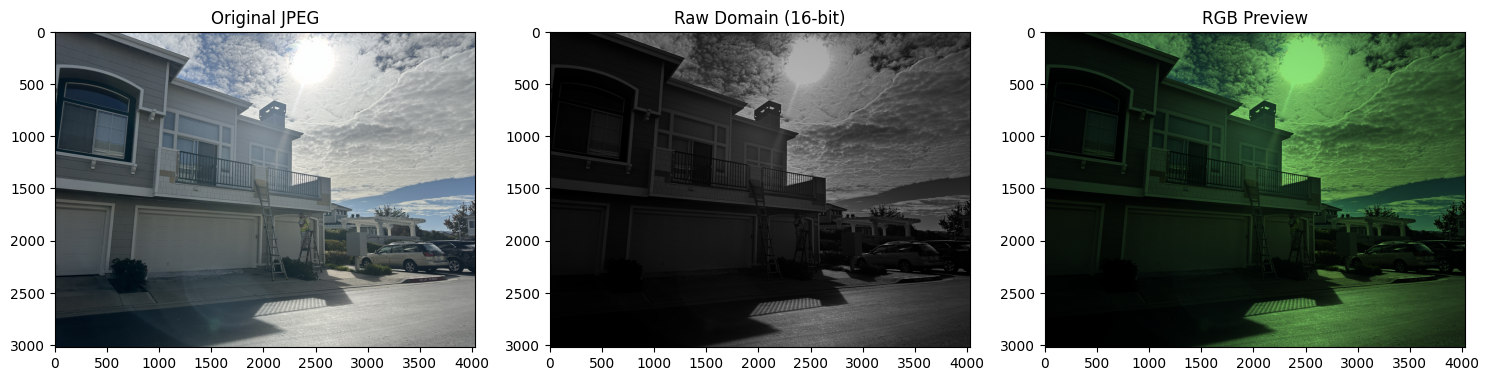

In [9]:
#process_and_display(jpg_path, color_temperature=6500, falloff_percentage=0, bayer_first_pixel='R', gamma=2.2, defect_percentage=0.01):
raw_img, preview = process_and_display('/content/IMG_1724.JPG', color_temperature=5100, falloff_percentage=30, bayer_first_pixel='R', defect_percentage= 0.002)


ct = 3400, r = 0.8414372357925366, g = 1.0, b = 0.33239659834434904


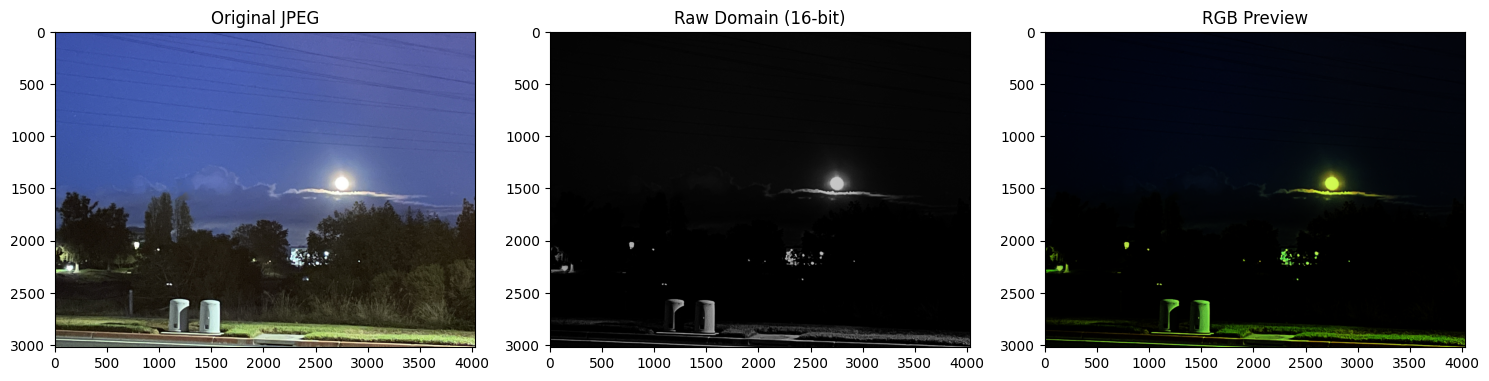

In [19]:
raw_img, preview = process_and_display('//content/IMG_4437.JPG', color_temperature=3400, falloff_percentage=30, bayer_first_pixel='R', defect_percentage= 0.005, gamma=3.75)